optimal_value = 2296.0
objective = 2296.0
result = 2296.0

详细列车时刻表 / Detailed Train Schedule

列车 G1 时刻表:
--------------------------------------------------
车站       到达时间       出发时间       停站时间       停站标识    
--------------------------------------------------
A        138.0      138.0      0.0        停站      
B        146.0      148.0      2.0        停站      
C        158.0      160.0      2.0        停站      
D        173.0      175.0      2.0        停站      
E        184.0      184.0      0.0        通过      
F        203.0      203.0      0.0        通过      
G        223.0      223.0      0.0        通过      
H        230.0      232.0      2.0        停站      
I        245.0      245.0      0.0        通过      
J        263.0      265.0      2.0        停站      
K        284.0      286.0      2.0        停站      
L        305.0      305.0      0.0        通过      
M        319.0      321.0      2.0        停站      
N        328.0      330.0      2.0        停站      
O        336.0      336.0   

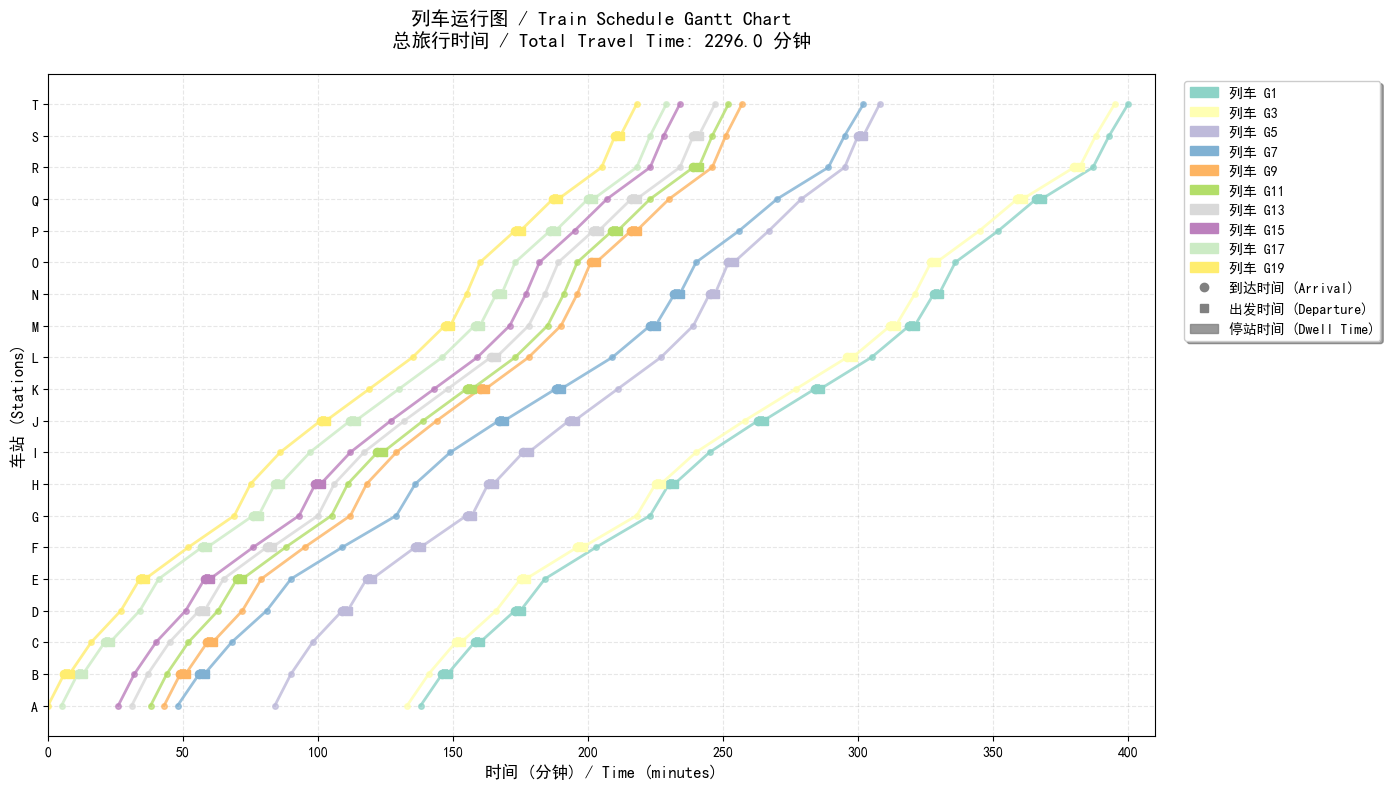

✅ 甘特图生成成功!

所有决策变量的最优值:
A[G1,A] = 138.0
A[G1,B] = 146.0
A[G1,C] = 158.0
A[G1,D] = 173.0
A[G1,E] = 184.0
A[G1,F] = 203.0
A[G1,G] = 223.0
A[G1,H] = 230.0
A[G1,I] = 245.0
A[G1,J] = 263.0
A[G1,K] = 284.0
A[G1,L] = 305.0
A[G1,M] = 319.0
A[G1,N] = 328.0
A[G1,O] = 336.0
A[G1,P] = 352.0
A[G1,Q] = 366.0
A[G1,R] = 387.0
A[G1,S] = 393.0
A[G1,T] = 400.0
A[G3,A] = 133.0
A[G3,B] = 141.0
A[G3,C] = 151.0
A[G3,D] = 166.0
A[G3,E] = 175.0
A[G3,F] = 196.0
A[G3,G] = 218.0
A[G3,H] = 225.0
A[G3,I] = 240.0
A[G3,J] = 258.0
A[G3,K] = 277.0
A[G3,L] = 296.0
A[G3,M] = 312.0
A[G3,N] = 321.0
A[G3,O] = 327.0
A[G3,P] = 345.0
A[G3,Q] = 359.0
A[G3,R] = 380.0
A[G3,S] = 388.0
A[G3,T] = 395.0
A[G5,A] = 84.0
A[G5,B] = 90.0
A[G5,C] = 98.0
A[G5,D] = 109.0
A[G5,E] = 118.0
A[G5,F] = 136.0
A[G5,G] = 155.0
A[G5,H] = 163.0
A[G5,I] = 176.0
A[G5,J] = 193.0
A[G5,K] = 211.0
A[G5,L] = 227.0
A[G5,M] = 239.0
A[G5,N] = 245.0
A[G5,O] = 252.0
A[G5,P] = 267.0
A[G5,Q] = 279.0
A[G5,R] = 295.0
A[G5,S] = 300.0
A[G5,T] = 308.0
A[G7,A] = 48.0
A[G7

In [11]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import numpy as np

# Create model
model = gp.Model("optimization_problem")

# --- Data Reading ---
data_file_path = "/Users/luhongliang/Desktop/Research/LLM4OPT/OptAgent-langgraph/benchmark/rail-data/test/my_data.xlsx"

# 1. Read 'station' sheet
df_station = pd.read_excel(data_file_path, sheet_name='station')
stations = df_station['station'].tolist()

# 2. Read 'train' sheet
df_train = pd.read_excel(data_file_path, sheet_name='train')
trains = df_train['trainNO'].tolist()
train_speeds_map = df_train.set_index('trainNO')['speed'].astype(str).to_dict() # Speed class as string for lookup

# Prepare train_stop_flags: {(trainNO, station): 1/0}
train_stop_flags = {}
for _, row in df_train.iterrows():
    train_no = row['trainNO']
    for station_name in stations:
        if station_name in row.index:
            train_stop_flags[(train_no, station_name)] = row[station_name]
        else:
            train_stop_flags[(train_no, station_name)] = 0 # Default to not stopping if column not found


# 3. Read 'runtime' sheet
df_runtime = pd.read_excel(data_file_path, sheet_name='runtime')
runtimes_map = {} # {(from_station, to_station, speed_class_str): runtime_value}
for _, row in df_runtime.iterrows():
    station_pair_str = row['station']
    from_station, to_station = station_pair_str.split('-')
    for speed_col in df_runtime.columns:
        if speed_col != 'station':
            runtimes_map[(from_station, to_station, speed_col)] = row[speed_col]

# 4. Read 'parameter' sheet (FIXED: Correctly read transposed parameters)
df_parameter_raw = pd.read_excel(data_file_path, sheet_name='parameter', header=None)
parameter_names = df_parameter_raw.iloc[0].tolist()
parameter_values = df_parameter_raw.iloc[1].tolist()
parameters = dict(zip(parameter_names, parameter_values))

MAX_TIME = int(parameters['T'])
MIN_HEADWAY = int(parameters['H'])
MIN_STOP_TIME = int(parameters['MINSTOP'])
MAX_STOP_TIME = int(parameters['MAXSTOP'])

# Derived sets and parameters
first_station = stations[0]
last_station = stations[-1]
intermediate_stations = [s for s in stations if s not in [first_station, last_station]]
BIG_M = MAX_TIME # A sufficiently large number for Big-M constraints

# Suppress Gurobi output for cleaner run
model.setParam('OutputFlag', 0)

def plot_train_schedule_gantt(A_vars, D_vars, trains, stations, train_stop_flags, model_obj_val):
    """
    绘制列车运行甘特图
    
    Args:
        A_vars: 到达时间变量字典 {(train, station): value}
        D_vars: 出发时间变量字典 {(train, station): value}
        trains: 列车列表
        stations: 车站列表
        train_stop_flags: 停站标识字典 {(train, station): 0/1}
        model_obj_val: 模型最优值
    """
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 颜色映射
    colors = plt.cm.Set3(np.linspace(0, 1, len(trains)))
    train_colors = {train: colors[i] for i, train in enumerate(trains)}
    
    # 绘制每列列车的运行线
    for i, train in enumerate(trains):
        train_times = []
        train_stations = []
        
        # 收集该列车在各站的时间信息
        for station in stations:
            arrival_time = A_vars.get((train, station), 0)
            departure_time = D_vars.get((train, station), 0)
            
            train_times.append((arrival_time, departure_time))
            train_stations.append(station)
        
        # 绘制运行线段
        for j, station in enumerate(stations):
            arrival_time, departure_time = train_times[j]
            
            # 在车站的停留时间（如果有）
            if train_stop_flags.get((train, station), 0) == 1 and arrival_time != departure_time:
                # 停站：绘制水平线段表示停留
                ax.barh(j, departure_time - arrival_time, left=arrival_time, 
                       height=0.3, color=train_colors[train], alpha=0.8,
                       label=f'{train}' if j == 0 else "")
                
                # 添加停站标记
                ax.plot(arrival_time, j, 'o', color=train_colors[train], markersize=6)
                ax.plot(departure_time, j, 's', color=train_colors[train], markersize=6)
            else:
                # 通过站：绘制点
                ax.plot(arrival_time, j, 'o', color=train_colors[train], markersize=4, alpha=0.7)
            
            # 绘制区间运行线（连接相邻车站）
            if j < len(stations) - 1:
                next_arrival_time = train_times[j + 1][0]
                ax.plot([departure_time, next_arrival_time], [j, j + 1], 
                       '-', color=train_colors[train], linewidth=2, alpha=0.8)
    
    # 设置图形属性
    ax.set_yticks(range(len(stations)))
    ax.set_yticklabels(stations)
    ax.set_ylabel('车站 (Stations)', fontsize=12, fontweight='bold')
    ax.set_xlabel('时间 (分钟) / Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_title(f'列车运行图 / Train Schedule Gantt Chart\n总旅行时间 / Total Travel Time: {model_obj_val:.1f} 分钟', 
                fontsize=14, fontweight='bold', pad=20)
    
    # 设置网格
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # 设置时间轴范围
    all_times = []
    for train in trains:
        for station in stations:
            all_times.extend([A_vars.get((train, station), 0), D_vars.get((train, station), 0)])
    
    if all_times:
        min_time = max(0, min(all_times) - 5)
        max_time = max(all_times) + 10
        ax.set_xlim(min_time, max_time)
    
    # 添加图例
    legend_elements = []
    for train in trains:
        legend_elements.append(mpatches.Patch(color=train_colors[train], label=f'列车 {train}'))
    
    # 添加符号说明
    legend_elements.extend([
        plt.Line2D([0], [0], marker='o', color='gray', linestyle='None', 
                  markersize=6, label='到达时间 (Arrival)'),
        plt.Line2D([0], [0], marker='s', color='gray', linestyle='None', 
                  markersize=6, label='出发时间 (Departure)'),
        mpatches.Patch(color='gray', alpha=0.8, label='停站时间 (Dwell Time)')
    ])
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
             fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"train_schedule_gantt_chart_{timestamp}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"甘特图已保存为: {filename}")
    
    # 显示图形
    plt.show()
    
    return filename

def print_detailed_schedule(A_vars, D_vars, trains, stations, train_stop_flags):
    """
    打印详细的列车时刻表
    """
    print("\n" + "="*80)
    print("详细列车时刻表 / Detailed Train Schedule")
    print("="*80)
    
    for train in trains:
        print(f"\n列车 {train} 时刻表:")
        print("-" * 50)
        print(f"{'车站':<8} {'到达时间':<10} {'出发时间':<10} {'停站时间':<10} {'停站标识':<8}")
        print("-" * 50)
        
        total_travel_time = 0
        for station in stations:
            arrival = A_vars.get((train, station), 0)
            departure = D_vars.get((train, station), 0)
            dwell_time = departure - arrival
            stop_flag = train_stop_flags.get((train, station), 0)
            stop_status = "停站" if stop_flag == 1 else "通过"
            
            print(f"{station:<8} {arrival:<10.1f} {departure:<10.1f} {dwell_time:<10.1f} {stop_status:<8}")
        
        # 计算该列车的总旅行时间
        first_station = stations[0]
        last_station = stations[-1]
        travel_time = A_vars.get((train, last_station), 0) - D_vars.get((train, first_station), 0)
        print(f"\n列车 {train} 总旅行时间: {travel_time:.1f} 分钟")
        total_travel_time += travel_time
    
    print(f"\n所有列车总旅行时间: {total_travel_time:.1f} 分钟")

# Decision variables
# A_is: Arrival time of train i at station s
A = model.addVars(trains, stations, vtype=GRB.CONTINUOUS, lb=0, ub=MAX_TIME, name="A")
# D_is: Departure time of train i from station s
D = model.addVars(trains, stations, vtype=GRB.CONTINUOUS, lb=0, ub=MAX_TIME, name="D")

# x_ij: Binary variable for train order (1 if i precedes j, 0 otherwise)
train_pairs = [(i, j) for idx_i, i in enumerate(trains) for idx_j, j in enumerate(trains) if idx_i < idx_j]
x = model.addVars(train_pairs, vtype=GRB.BINARY, name="x")

# Objective function
# Minimize total travel time for all trains
obj_expr = gp.quicksum(A[i, last_station] - D[i, first_station] for i in trains)
model.setObjective(obj_expr, GRB.MINIMIZE)

# Constraints
# 2. Running Time Constraints
for i in trains:
    for s_idx in range(len(stations) - 1):
        s_current = stations[s_idx]
        s_next = stations[s_idx + 1]
        speed_class = train_speeds_map[i]
        
        run_duration = runtimes_map.get((s_current, s_next, speed_class))
        
        if run_duration is not None:
            model.addConstr(D[i, s_current] + run_duration == A[i, s_next],
                            name=f"RunTime_T{i}_S{s_current}_S{s_next}")
        else:
            print(f"WARNING: No runtime for train {i} (speed {speed_class}) from {s_current} to {s_next}.")

# 3. Dwell Time Constraints
for i in trains:
    for s in stations:
        # a. Departure must be after or at arrival time
        model.addConstr(A[i, s] <= D[i, s], name=f"DepAfterArr_T{i}_S{s}")

        # b. and c. Handle intermediate stations based on stop flag
        if s in intermediate_stations:
            if train_stop_flags[(i, s)] == 1: # Train stops at intermediate station
                model.addConstr(D[i, s] - A[i, s] >= MIN_STOP_TIME,
                                name=f"MinStop_T{i}_S{s}")
                model.addConstr(D[i, s] - A[i, s] <= MAX_STOP_TIME,
                                name=f"MaxStop_T{i}_S{s}")
            else: # Train passes through intermediate station (stop_flag 0)
                model.addConstr(D[i, s] - A[i, s] == 0,
                                name=f"PassThrough_T{i}_S{s}")
        # d. Special handling for origin and destination stations (dwell time always 0)
        elif s == first_station or s == last_station:
            model.addConstr(D[i, s] - A[i, s] == 0,
                            name=f"DwellZero_T{i}_S{s}")

# 4. Headway and No-Overtaking Constraints
for i, j in train_pairs:
    for s in stations:
        # If x[i,j] = 1 (train i precedes train j):
        model.addConstr(A[j, s] - A[i, s] >= MIN_HEADWAY - BIG_M * (1 - x[i, j]),
                        name=f"HeadwayArr_ij_T{i}_T{j}_S{s}")
        model.addConstr(D[j, s] - D[i, s] >= MIN_HEADWAY - BIG_M * (1 - x[i, j]),
                        name=f"HeadwayDep_ij_T{i}_T{j}_S{s}")

        # If x[i,j] = 0 (train j precedes train i):
        model.addConstr(A[i, s] - A[j, s] >= MIN_HEADWAY - BIG_M * x[i, j],
                        name=f"HeadwayArr_ji_T{i}_T{j}_S{s}")
        model.addConstr(D[i, s] - D[j, s] >= MIN_HEADWAY - BIG_M * x[i, j],
                        name=f"HeadwayDep_ji_T{i}_T{j}_S{s}")

# Solve
model.optimize()

# Extract results
if model.Status == GRB.OPTIMAL:
    print(f"optimal_value = {model.ObjVal}")
    print(f"objective = {model.ObjVal}")
    print(f"result = {model.ObjVal}")
    
    # Extract solution values for visualization
    A_solution = {}
    D_solution = {}
    
    for var in model.getVars():
        if var.VarName.startswith('A['):
            # Parse variable name A[train,station]
            var_name = var.VarName[2:-1]  # Remove 'A[' and ']'
            train, station = var_name.split(',')
            A_solution[(train, station)] = var.X
        elif var.VarName.startswith('D['):
            # Parse variable name D[train,station]
            var_name = var.VarName[2:-1]  # Remove 'D[' and ']'
            train, station = var_name.split(',')
            D_solution[(train, station)] = var.X
    
    # Print detailed schedule
    print_detailed_schedule(A_solution, D_solution, trains, stations, train_stop_flags)
    
    # Generate and save Gantt chart
    print("\n" + "="*80)
    print("生成列车运行甘特图...")
    try:
        chart_filename = plot_train_schedule_gantt(
            A_solution, D_solution, trains, stations, train_stop_flags, model.ObjVal
        )
        print(f"✅ 甘特图生成成功!")
    except Exception as e:
        print(f"❌ 甘特图生成失败: {str(e)}")
    
    # Print all decision variables with their optimal values (optional, can be commented out)
    print("\n" + "="*80)
    print("所有决策变量的最优值:")
    print("="*80)
    for var in model.getVars():
        if var.X > 1e-6 or (var.VarName.startswith('x') and var.X < 0.5): # Print all binary vars, and non-zero continuous vars
            print(f"{var.VarName} = {var.X}")
 
else:
    print(f"Optimization status: {model.Status}")
    if model.Status == GRB.INFEASIBLE:
        print("optimal_value = INFEASIBLE")
        print("❌ 问题不可行，无法生成甘特图")
    elif model.Status == GRB.UNBOUNDED:
        print("optimal_value = UNBOUNDED")
        print("❌ 问题无界，无法生成甘特图")
    else:
        print("optimal_value = ERROR")
        print("❌ 求解出错，无法生成甘特图")

In [7]:
from rail_data_generator import RailDataGenerator

# 创建生成器
generator = RailDataGenerator(
    num_stations=30,      # 车站数量
    num_trains=50,        # 列车数量
    speed_classes=['300', '350'],  # 速度等级
    max_distance=300,    # 线路总长度(km)
    time_limit=1000,      # 时间上限(分钟)
    min_headway=5,       # 最小间隔时间(分钟)
    min_stop_time=2,     # 最小停站时间(分钟)
    max_stop_time=15,    # 最大停站时间(分钟)
    stop_probability=0.3, # 中间站停站概率
    random_seed=42       # 随机种子
)

# 生成数据
data = generator.generate_data('my_data_large.xlsx')

# 查看数据摘要
generator.print_data_summary(data)


正在生成数据...
- 车站数量: 30
- 列车数量: 50
- 速度等级: ['300', '350']
- 线路长度: 300km
数据已保存到: my_data_large.xlsx

=== 数据摘要 ===

1. 车站信息 (30 个车站):
station  mile
     S1     0
     S2    13
     S3    17
     S4    41
     S5    46
     S6    46
     S7    54
     S8    55
     S9    59
    S10    63
    S11    87
    S12    87
    S13    91
    S14   109
    S15   112
    S16   129
    S17   136
    S18   154
    S19   157
    S20   177
    S21   179
    S22   180
    S23   183
    S24   212
    S25   219
    S26   235
    S27   249
    S28   259
    S29   285
    S30   300

2. 列车信息 (50 列列车):
trainNO speed  S1  S2  S3  S4  S5  S6  S7  S8  S9  S10  S11  S12  S13  S14  S15  S16  S17  S18  S19  S20  S21  S22  S23  S24  S25  S26  S27  S28  S29  S30
     G1   300   1   1   1   1   0   0   0   1   0    1    1    0    1    1    0    0    1    0    0    1    0    0    0    1    0    0    1    1    0    1
     G3   350   1   0   0   0   0   0   0   0   0    0    0    0    1    1    1    1    1    1    1    0    